# Power Comparisons

The purpose of this notebook is to compare methods of power comparison for use in field test results of wind farm controls

In [27]:
%matplotlib inline

import sys
import imp
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Problem Definition

In [37]:
N = 100 # Number of data points
powGain = 1.05 # Multiplier from turbRef to turbC
noiseAmp = 200 # kW, determines amplitude of random noise

# Note that when turbRef is generated, the max is 7MW and this is clipped down to 5MW, to force the distribution to include
# a number of points at exactly 5MW, to make the fitting problem more realistic
turbRef = np.random.uniform(low = 100., high = 7000.,size=N)
turbC = powGain * turbRef + np.random.normal(loc = 0.0, scale=noiseAmp, size = N)

# Coerce into range
turbRef = np.clip(turbRef,0.,5000.)
turbC = np.clip(turbC,0.,5000.)

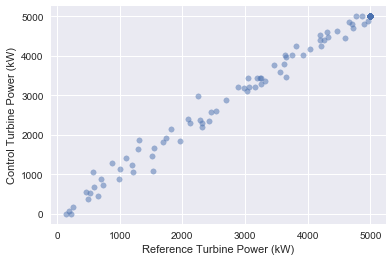

In [57]:
# Compare the power in a plot
fig, ax = plt.subplots()
ax.scatter(turbRef, turbC, s=30,alpha=0.5)
ax.set_xlabel('Reference Turbine Power (kW)')
ax.set_ylabel('Control Turbine Power (kW)')

## Evaluation Functions

Before defining functions for determination of offsets, define a function to evaluate the answers with bootstrapping

In [106]:
# define a boostrap function
# Ref: https://machinelearningmastery.com/calculate-bootstrap-confidence-intervals-machine-learning-results-python/
def bootstrap(x, y,fit_func, n_iterations = 100, n_use = 0.5):

    
    fit_values = np.zeros(n_iterations)
    n_size = n_size = int(len(x) * n_use)
    
    for idx in range(n_iterations):
        random_index = np.random.randint(0,len(x),size=n_size)
        sub_x = x[random_index]
        sub_y = y[random_index]
        #data_sub = np.random.choice(data,size=n_size,replace=True)
        fit_values[idx] = fit_func(sub_x,sub_y)
        
    # Gather statistics of results
    meanVal = np.mean(fit_values)
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    lower = np.percentile(fit_values, p)
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = np.percentile(fit_values, p)
    print('%.1f confidence interval %.2f and %.2f' % (alpha*100, lower, upper))
    return meanVal, lower, upper, fit_values
    

## Power Ratios

A first naive approach would be to compute power ratios, and then statistics on those ratios, looked at in this section

In [107]:
def powRatio(x,y):
    return np.mean(y/x) # simply return the ratio of all the mean values

In [108]:
# Compute the statistics through bootstrapping of this appoach
ratio_meanVal, ratio_lower, ratio_upper, ratio_fit_values = bootstrap(x=turbRef,y=turbC,fit_func=powRatio)

95.0 confidence interval 0.95 and 1.08


## Slope fit method

This is an example method which uses fit slope to help with the noise,
Also, data where the reference turbine is near rated is thrown out in this method or it biases the slope

0.96444123347325073

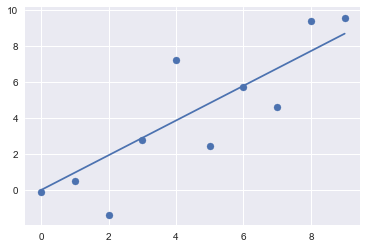

In [110]:
# First define a slope fitting method
def fitSlope(x,y,plot=False):
    x = x[:,np.newaxis]
    a, _, _, _ = np.linalg.lstsq(x, y)
    
    if plot:
        fig, ax = plt.subplots()
        ax.scatter(x,y)
        ax.plot(x,a*x) 
    return a[0]

xTest = np.arange(0.,10.,1.)
yTest = xTest + 2 *np.random.normal(size=len(xTest))
fitSlope(xTest,yTest,plot=True)

In [111]:
# First remove rated and near-rated points from reference turbine
powerThreshold = 4500 #kW
turbC_limit = turbC[turbRef <= powerThreshold]
turbRef_limit = turbRef[turbRef <= powerThreshold]

In [112]:
# Now get stats for this method
slope_meanVal, slope_lower, slope_upper, slope_fit_values = bootstrap(x=turbRef_limit,y=turbC_limit,fit_func=fitSlope)

95.0 confidence interval 1.03 and 1.07


## Compare the statistics of the methods

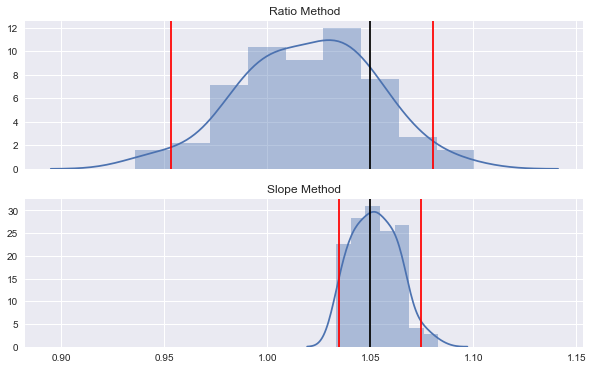

In [117]:
# Show in a plot this method
# Black vertical line is "true" power gain
# Red lines confidence interval

fig, axarr = plt.subplots(2,1,figsize=(10,6),sharex=True)

ax = axarr[0]
ax.set_title('Ratio Method')
sns.distplot(ratio_fit_values,ax=ax)
ax.axvline(ratio_lower,color='r')
ax.axvline(ratio_upper,color='r')
ax.axvline(powGain,color='k')

ax = axarr[1]
ax.set_title('Slope Method')
sns.distplot(slope_fit_values,ax=ax)
ax.axvline(slope_lower,color='r')
ax.axvline(slope_upper,color='r')
ax.axvline(powGain,color='k')